# Выбор локации для скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.  

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Необходимо проанализировать возможную прибыль и риски.  

Шаги для выбора локации:  
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;  
- Строят модель и оценивают объём запасов;  
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;  
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np

try:
    import matplotlib.pyplot as plt
except:
    !pip install --upgrade matplotlib==3.8.4
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    !pip install --upgrade seaborn==0.13
    import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Загрузка и подготовка данных
### Загрузка и предобработка данных

In [2]:
# Формула для оптимизации кода вывода первичной информации
def information(dataset):
    display(dataset.head())
    display()
    display(dataset.info())

In [3]:
# Загрузим первый датасет, сохраним его как `geo_data_0`, сразу сделаем столбец 'id' индексами
try:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', index_col='id')
except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', index_col='id')

# Изучим общую информацию о датасете `geo_data_0`
information(geo_data_0)

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

In [4]:
# Загрузим второй датасет, сохраним его как `geo_data_1`, сразу сделаем столбец 'id' индексами
try:
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', index_col='id')
except:
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', index_col='id')

# Изучим общую информацию о датасете `geo_data_1`
information(geo_data_1)

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

In [5]:
# Загрузим третий датасет, сохраним его как `geo_data_2`, сразу сделаем столбец 'id' индексами
try:
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', index_col='id')
except:
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', index_col='id')

# Изучим общую информацию о датасете `geo_data_2`
information(geo_data_2)

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

Данные загружены. Названия колонок корректные. Типы данных `float64`. Пропуски, по общей информации, отсутствуют. В каждом датафрейме 4 столбца и 100000 строк с данными. Проверим данные на наличие пропусков и явных дубликатов.

In [6]:
# Создаём словарь датафреймов `dfs`
dfs = {
    'geo_data_0': geo_data_0,
    'geo_data_1': geo_data_1,
    'geo_data_2': geo_data_2
}

# Создаём цикл для проверки на наличие пропусков и явных дубликатов в датафреймах из словаря `dfs`
for name, df in dfs.items():
    print(f'Название датафрейма: {name}\n')
    print(f'Количество пропусков\n{df.isna().sum()}\n')
    print(f'Количество дубликатов {df.duplicated().sum()}\n')
    print('-' * 40)

Название датафрейма: geo_data_0

Количество пропусков
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов 0

----------------------------------------
Название датафрейма: geo_data_1

Количество пропусков
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов 0

----------------------------------------
Название датафрейма: geo_data_2

Количество пропусков
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество дубликатов 0

----------------------------------------


Пропусков и явных дубликатов нет. Категориальных столбцов нет, в данных имеются только числовые значения, поэтому на неявные дубликаты проверку не проводим. Что означают характеристики `f0`, `f1`, `f2`, нам неизвестно. Изучим распределение объёма запасов в скважине в каждом регионе.

### Исследовательский анализ данных

In [7]:
# Напишем функцию для построения графиков распределения объёма запасов в скважине
# функция принимает в качестве агрументов датасет и название графика
def graphics(geo_data, feature_title):
    # задаём схему графика
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig.suptitle(feature_title)
    # строим гистограмму распределения
    sns.histplot(data=geo_data, x='product', bins=20, ax=axes[0])
    axes[0].set_title('Гистограмма распределения')
    # строим 'ящик с усами'
    sns.boxplot(data=geo_data,  y='product', ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    plt.show()
    # выводим численное описание данных
    print('Описание данных')
    print(df.describe().round(2))

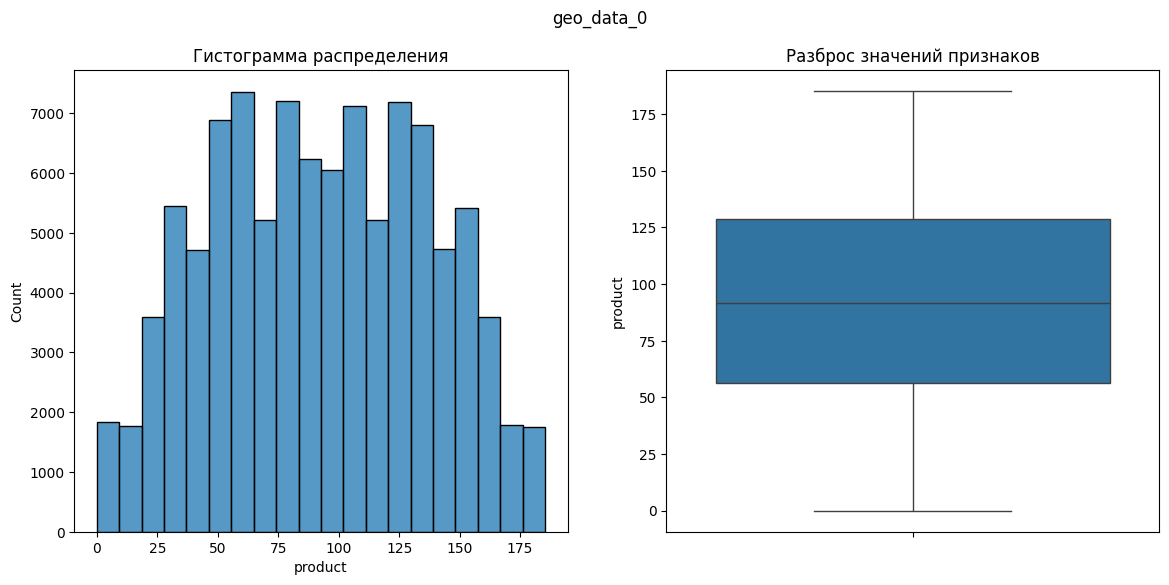

Описание данных
              f0         f1         f2    product
count  100000.00  100000.00  100000.00  100000.00
mean        0.50       0.25       2.50      92.50
std         0.87       0.50       3.25      44.29
min        -1.41      -0.85     -12.09       0.00
25%        -0.07      -0.20       0.29      56.50
50%         0.50       0.25       2.52      91.85
75%         1.07       0.70       4.72     128.56
max         2.36       1.34      16.00     185.36


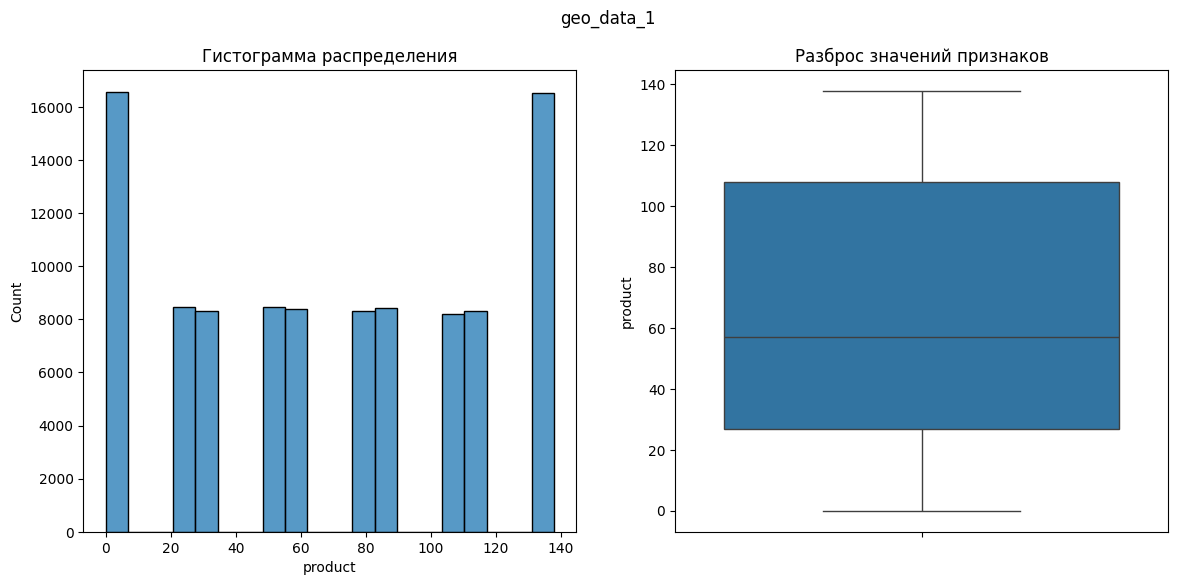

Описание данных
              f0         f1         f2    product
count  100000.00  100000.00  100000.00  100000.00
mean        1.14      -4.80       2.49      68.83
std         8.97       5.12       1.70      45.94
min       -31.61     -26.36      -0.02       0.00
25%        -6.30      -8.27       1.00      26.95
50%         1.15      -4.81       2.01      57.09
75%         8.62      -1.33       4.00     107.81
max        29.42      18.73       5.02     137.95


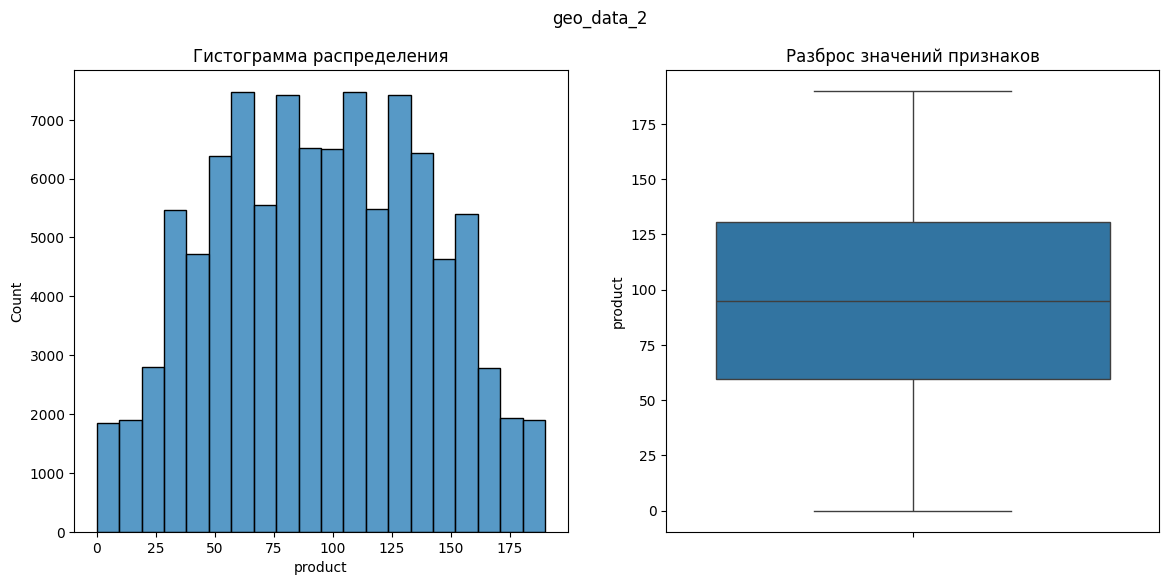

Описание данных
              f0         f1         f2    product
count  100000.00  100000.00  100000.00  100000.00
mean        0.00      -0.00       2.50      95.00
std         1.73       1.73       3.47      44.75
min        -8.76      -7.08     -11.97       0.00
25%        -1.16      -1.17       0.13      59.45
50%         0.01      -0.01       2.48      94.93
75%         1.16       1.16       4.86     130.60
max         7.24       7.84      16.74     190.03


In [8]:
# Создаём цикл для построения графиков распределения объёма запасов по датасетам из словаря `dfs`
for name, df in dfs.items():
    graphics(df, name)

Распределение скважин по объёму запасов в первом и третьем регионе похожее: медианное значение запасов 92-95 тыс. баррелей, половина скважин имеет запасы примерно от 56-59 до 128-130 тыс. баррелей, внешне распределение выглядит похожим на нормальное. Но во втором регионе распределение сильно отличается: медианное значение около 57 тыс. баррелей, половина скважин имеет запасы от 27 до 108 тыс. баррелей. Однако в этом регионе очень много скважин с близкими к нулю запасами и очень много скважин с высоким - около 130-140 тыс. баррелей. По внешнему виду "ящика с усами" можно сказать, что вариация объёма запасов во втором регионе самая большая ("ящик с усами" самый большой). Характеристики других признаков также сильно отличаются именно во втором регионе.

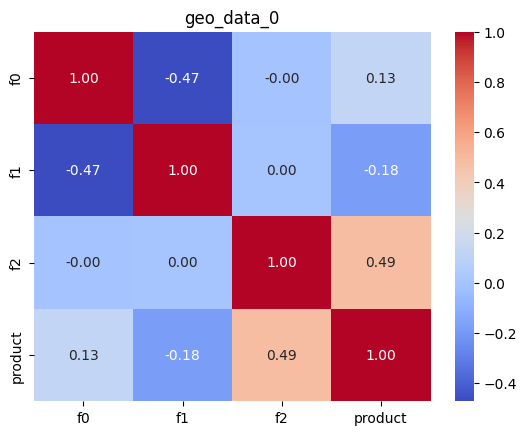

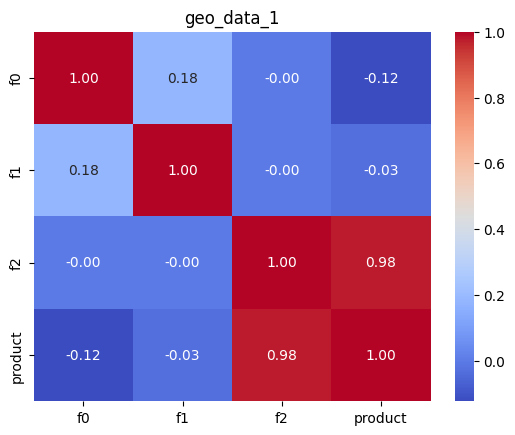

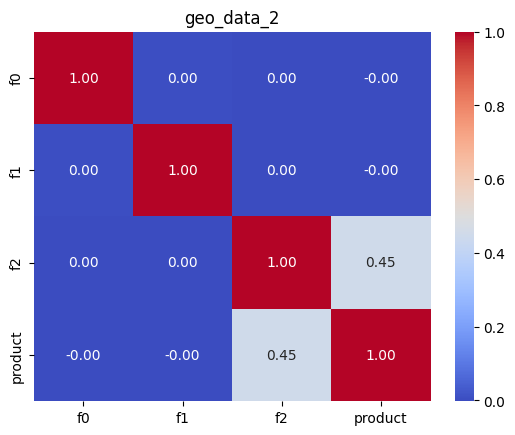

In [9]:
# Построим тепловые карты для каждого датафрейма (распределение признаков отличное от нормального,
# поэтому используем коэффициент корреляции Спирмена)
for name, df in dfs.items():
    sns.heatmap(df.corr(method='spearman'), cmap='coolwarm', annot=True, fmt='.2f')
    plt.title(name)
    plt.show()

Тепловые карты показывают, что во втором регионе зависимость между признаками `f2` (входной) и `product` (этот признак принимаем за целевой) очень сильная (коэффициент корреляции Спирмена равен 0,98). Это означает, что линейная регрессия должна сработать хорошо. В первом и третьем регионах один входной признак имеет взаимосвязь средней силы с целевым признаком. В третьем регионе два признака показывают абсолютное отсутствие взаимосвязи с целевым признаком, что неблагоприятно для модели линейной регрессии.

В данном проекте исследуются три региона. Мы будем обучать и использовать одну модель. Поэтому мы не используем пайплайны, а напишем функцию, которая будет применяться к данным по каждому региону.  
Целевой признак - объём запасов сырья. Входные признаки - `f0`, `f1`, `f2`. Признаки количественные, их нужно будет масштабировать. Категориальные признаки отсутствуют.  
Прежде всего, разделим данные на входные и целевой, а также на тренировочную и валидационную выборки. А затем выполним масштабирование. Это нужно сделать по каждому региону.

**Вывод.** Данные загружены, столбец `id` сразу переведён в индексы. Названия столбцов корректные. Проверка на пропуски и явные дубликаты проведена. Проверка не неявные дубликаты не проводилась, так как категориальные столбцы в данных отсутствуют. Данные только количественные. Распределение признаков `f0`, `f1`, `f2` не изучалось, так как неизвестно, что означают эти признаки. Распределение признака `produkt` изучено, во втором регионе оно сильно отличается от распределения в первом и третьем регионах: во втором регионе медианное значение объема запасов меньше, чем в двух других, но там значительно больше скважин как с почти нулевыми запасами, так и с очень большими объёмами запасов.  
Исходные данные будут разделены на входные и целевой признаки, а также на тренировочную и валидационную выборки. Все данные будут масштабированы. Это будет сделано при помощи одной функции перед обучением и проверкой модели.

## Обучение и проверка модели
По условию для обучения модели подходит только линейная регрессия (остальные - недостаточно предсказуемые). Напишем функцию для разделения и масштабирования исходных данных и обучения модели.

In [10]:
# Зададим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Напишем функцию для подготовки данных
def learning_linear_model(df):
    
    # разделение на тренировочную и тестовую выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop('product', axis=1),
        df['product'],
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    
    # масштабирование количественных признаков тренировочной и валидационной выборок
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    # создание датафреймов из масштабированных данных
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
    
    # инициализация и обучение модели
    model_lr = LinearRegression()
    model_lr.fit(X_train_scaled, y_train)
    
    # предсказанные значения для X_valid
    y_pred = model_lr.predict(X_valid_scaled)
    
    # оценим качество модели на валидационной выборке,
    # рассчитаем коэффициент RMSE для линейной регрессии
    rmse = round(mean_squared_error(
        y_valid,
        y_pred,
        squared=False
    ), 3)
    
    # Создаём таблицу с прогнозом объёмов запасов и настоящими значениями объёмов запасов
    pred_geo_data = pd.DataFrame(zip(y_pred, y_valid), columns=['y_pred', 'y_true'])
    
    y_pred_mean = round(pred_geo_data['y_pred'].mean(), 2)
                                
    # функция возвращает целевой признак реальный, предсказанный, значение метрики `rmse`,
    # таблицу с предсказаниями и настоящими значениями, средний запас предсказанного сырья
    return y_valid, y_pred, rmse, pred_geo_data, y_pred_mean

In [11]:
# Применим функцию к первому региону
y_valid_0, y_pred_0, rmse_0, pred_geo_data_0, y_pred_mean_0 = learning_linear_model(geo_data_0)
print('Прогноз объёмов запасов и настоящие значения в первом регионе')
print(pred_geo_data_0.head())
print(f'Средний запас предсказанного сырья в первом регионе: {y_pred_mean_0}')
print(f'RSME модели для первого региона: {rmse_0}')
print('-' * 40)

# Применим функцию ко второму региону
y_valid_1, y_pred_1, rmse_1, pred_geo_data_1, y_pred_mean_1 = learning_linear_model(geo_data_1)
print('Прогноз объёмов запасов и настоящие значения во втором регионе')
print(pred_geo_data_1.head())
print(f'Средний запас предсказанного сырья во втором регионе: {y_pred_mean_1}')
print(f'RSME модели для второго региона: {rmse_1}')
print('-' * 40)

# Применим функцию к третьему региону
y_valid_2, y_pred_2, rmse_2, pred_geo_data_2, y_pred_mean_2 = learning_linear_model(geo_data_2)
print('Прогноз объёмов запасов и настоящие значения в третьем регионе')
print(pred_geo_data_2.head())
print(f'Средний запас предсказанного сырья в третьем регионе: {y_pred_mean_2}')
print(f'RSME модели для третьего региона: {rmse_2}')

Прогноз объёмов запасов и настоящие значения в первом регионе
       y_pred      y_true
0  101.901017  122.073350
1   78.217774   48.738540
2  115.266901  131.338088
3  105.618618   88.327757
4   97.980185   36.959266
Средний запас предсказанного сырья в первом регионе: 92.4
RSME модели для первого региона: 37.757
----------------------------------------
Прогноз объёмов запасов и настоящие значения во втором регионе
       y_pred      y_true
0    0.844738    0.000000
1   52.921612   53.906522
2  135.110385  134.766305
3  109.494863  107.813044
4   -0.047292    0.000000
Средний запас предсказанного сырья во втором регионе: 68.71
RSME модели для второго региона: 0.89
----------------------------------------
Прогноз объёмов запасов и настоящие значения в третьем регионе
       y_pred      y_true
0   98.301916  117.441301
1  101.592461   47.841249
2   52.449099   45.883483
3  109.922127  139.014608
4   72.411847   84.004276
Средний запас предсказанного сырья в третьем регионе: 94.77
RSME м

**Вывод.** Самый точный прогноз модель линейной регрессии дала по второму региону: модель ошибается в среднем всего на 0,89 тыс. баррелей. Средний запас предсказанного сырья составил 68,7 тыс. баррелей. В первом и третьем регионах RSME (средняя ошибка модели) составил 37,8 и 40,1 тыс. баррелей соответственно, а средний запас предсказанного сырья составил 92,4 и 94,8 тыс. баррелей соответственно. Итак, во втором регионе запасы предсказаны в среднем по объёму меньше, но точнее.

## Подготовка к расчёту прибыли
Все ключевые значения для расчётов сохраним в отдельных переменных.

In [12]:
# Общее число имеющихся в регионе точек
POINTS_TOTAL = 100000

# Общее число точек при разведке региона
NUMBER_POINTS = 500

# Число лучших для разработки точек в регионе
NUMBER_POINTS_BEST = 200

# Бюджет на разработку скважин в регионе, тыс. руб.
BUDGET_TOTAL = 10000000

# Доход с каждой единицы продукта (с 1 тыс. баррелей), тыс. руб.
INCOME = 450

# Порог вероятности убытков
T = 0.025

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Для этого бюджет на разработку одной скважины должен быть равен доходу с одной скважины.

In [13]:
# Бюджет на разработку одной скважины
budget = BUDGET_TOTAL / NUMBER_POINTS_BEST

# Необходимый объём сырья для безубыточной разработки скважины
product_breakeven = budget / INCOME

print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {round(product_breakeven, 2)} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


In [14]:
# Создадим список с предсказанным средним запасом сырья в каждом регионе
predictions_mean = [y_pred_mean_0.round(2), y_pred_mean_1.round(2), y_pred_mean_2.round(2)]

print(f'Предсказанный средний объём сырья в каждой скважине в трёх регионах: {predictions_mean}')

Предсказанный средний объём сырья в каждой скважине в трёх регионах: [92.4, 68.71, 94.77]


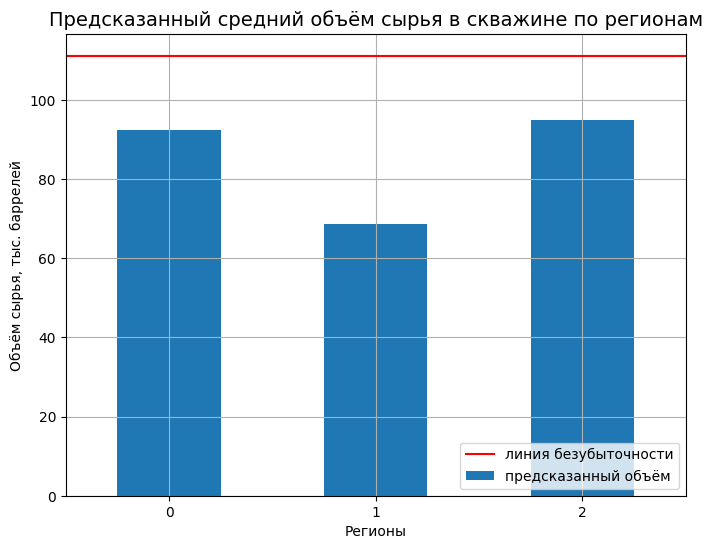

In [15]:
# Изобразим графически предсказанный средний объём сырья в трёх регионах,
# отметим линией достаточный объём сырья для безубыточной разработки новой скважины
pred = pd.Series(predictions_mean)

fig = plt.figure(figsize=(8, 6))
pred.plot(kind='bar', label='предсказанный объём')
plt.title('Предсказанный средний объём сырья в скважине по регионам', fontsize=14)
plt.xlabel('Регионы')
plt.ylabel('Объём сырья, тыс. баррелей')
plt.xticks(rotation='horizontal')
plt.axhline(product_breakeven, 0, 2.5, linestyle='-', color="r", label='линия безубыточности')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**Вывод.** Средний предсказанный объём сырья в одной скважине во всех трёх регионах меньше достаточного объёма сырья для безубыточной разработки новой скважины. Очевидно, что все скважины подряд в регионах разрабатывать нерентабельно. Необходимо выбрать скважины с максимальными значениями предсказаний, просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям и рассчитать прибыль для полученного объёма сырья. Это нужно выполнить для каждого из трёх регионов по отдельности.

## Расчёт прибыли и рисков

In [16]:
# Создадим переменные `target` и `pred` для каждого региона
target_0 = pred_geo_data_0['y_true']
pred_0 = pred_geo_data_0['y_pred']
target_1 = pred_geo_data_1['y_true']
pred_1 = pred_geo_data_1['y_pred']
target_2 = pred_geo_data_2['y_true']
pred_2 = pred_geo_data_2['y_pred']

In [17]:
# Напишем функцию для определения прибыли по выбранным скважинам и предсказаниям модели

# функции будем передавать истинные значения запасов, предсказания запасов и количество скважин
def profit(target, pred, count):
    
    # сортируем предсказанные значения в порядке убывания
    pred_sorted = pred.sort_values(ascending=False)
    
    # выбираем настоящие значения запасов в заданном количестве скважин с лучшими предсказаниями
    selected = target[pred_sorted.index][:count]
    
    # считаем общий доход в этих отобранных точках
    income_total = INCOME * selected.sum()
    
    # считаем общую прибыль: доход минус себестоимость
    revenue_total = income_total - BUDGET_TOTAL
    
    # функция возвращает общую прибыль от разработки выбранных скважин в регионе
    return revenue_total

# Выбираем по 500 скважин с лучшими предсказаниями в каждом регионе, применяем функцию
print(f'Общая прибыль от 500 точек в первом регионе: {round(profit(target_0, pred_0, NUMBER_POINTS))} тыс. руб.')
print(f'Общая прибыль от 500 точек во втором регионе: {round(profit(target_1, pred_1, NUMBER_POINTS))} тыс. руб.')
print(f'Общая прибыль от 500 точек в третьем регионе: {round(profit(target_2, pred_2, NUMBER_POINTS))} тыс. руб.')

Общая прибыль от 500 точек в первом регионе: 22555560 тыс. руб.
Общая прибыль от 500 точек во втором регионе: 21037717 тыс. руб.
Общая прибыль от 500 точек в третьем регионе: 20868210 тыс. руб.


Мы не можем сказать, что наблюдения описываются нормальным законом, поэтому для проверки гипотез не применяем ttest.  
Будем использовать технику Bootstrap.  
Доверительный интервал по условию должен быть 95 %, то есть вероятность рассчитанного среднего уровня прибыли должна быть 95 %. Поэтому нужно найти 0,025 и 0,975 квантили.

In [18]:
# Создаём функцию для расчёта прибыли и рисков с применением бутстрепа
def calc_profit_risk(target, pred):
    
    # задаём константу
    STATE = np.random.RandomState(12345)
    
    # создаём переменную для списка оценок прибыли из бутстрепа
    values = []
    
    # выполним процедуру Bootstrap с 1000 повторений
    for i in range(1000):
        target_subsample = target.sample(NUMBER_POINTS, replace=True, random_state=STATE)
        pred_subsample = pred[target_subsample.index]
        values.append(profit(target_subsample, pred_subsample, NUMBER_POINTS_BEST))
        
    # поменяем формат списка на Series
    values = pd.Series(values)
    
    # рассчитаем среднюю прибыль, риск убытков и доверительный интервал
    mean_profits = round(values.mean(), 1)
    risk_loss = round((values < 0).mean() * 100, 1)
    conf_interval = [round(values.quantile(0.025), 1), round(values.quantile(0.975), 1)]
    
    # функция возвращает оценки прибыли из бутстрепа, среднюю прибыль, риск убытков и доверительный интервал
    return values, mean_profits, risk_loss, conf_interval

In [19]:
# Применим функцию к трём регионам
values_0, mean_profits_0, risk_loss_0, conf_interval_0 = calc_profit_risk(target_0, pred_0)
values_1, mean_profits_1, risk_loss_1, conf_interval_1 = calc_profit_risk(target_1, pred_1)
values_2, mean_profits_2, risk_loss_2, conf_interval_2 = calc_profit_risk(target_2, pred_2)

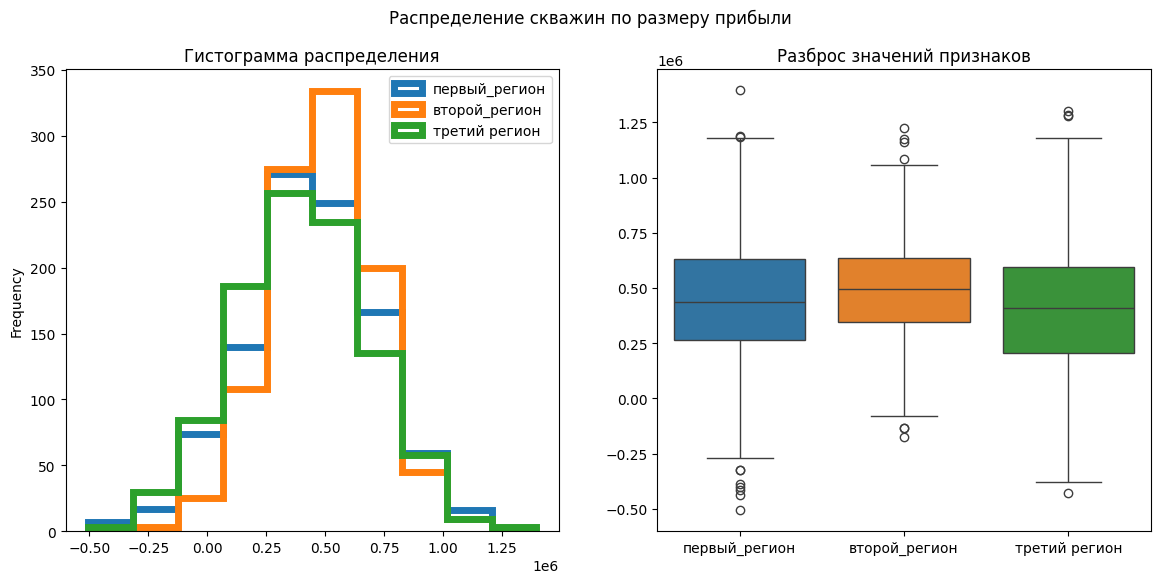

In [20]:
# Построим графики распределения скважин по размеру прибыли в регионах
# создаём датафрейм из оценок прибыли по трём регионам
values_total = pd.DataFrame(zip(values_0, 
                                values_1, 
                                values_2), columns=[
    'первый_регион',
    'второй_регион', 
    'третий регион'])
# задаём общий вид графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.suptitle('Распределение скважин по размеру прибыли')
# строим гистограммы распределения
values_total.plot(kind='hist', histtype='step', linewidth=5, legend=True, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
# строим 'ящики с усами'
sns.boxplot(data=values_total)
axes[1].set_title('Разброс значений признаков')
plt.show()

На графиках видно, что во втором регионе значительно меньше отрицательных значений прибыли, медианное значение прибыли выше и вариация прибыли меньше, чем в первом и третьем регионах.

In [21]:
# Создадим датафрейм с результатами работы функции
results = [
    [mean_profits_0, risk_loss_0, conf_interval_0],
    [mean_profits_1, risk_loss_1, conf_interval_1],
    [mean_profits_2, risk_loss_2, conf_interval_2]
]

data = pd.DataFrame(results, columns=['mean_profits', 'risk_loss', 'conf_intervals'])
data

,mean_profits,risk_loss,conf_intervals
0,435933.8,6.1,"[-116231.6, 966504.2]"
1,489661.3,1.1,"[55116.2, 905762.7]"
2,403687.9,7.1,"[-153117.0, 952887.4]"


**Вывод.** Результаты расчёта прибыли и риска убытков показывают, что самый низкий риск убытков во втором регионе (1,1 %). В первом регионе риск убытков 6,1 %, в третьем - 7,1 %. Средняя прибыль от одной скважины выше также во втором регионе: 489661,3 тыс. руб. В первом и третьем регионах прибыль составляет соответственно 435933,8 и 403687,9 тыс. руб. Таким образом, регион, подходящий для разработки - второй.

Итак, проведено исследование характеристик скважин с целью выбора лучшего региона для разработки.  

Данные загружены, проверены на пропуски и дубликаты, рассмотрено распределение целевого признака, наличие взаимосвязи между признаками. Распределение целевого признака - объёма запасов сырья - во втором регионе сильно отличается от распределения в первом и третьем регионах. Существует взаимосвязь некоторых входных признаков с целевым, во втором регионе - сильная.  

Исходные данные будут разделены на входные и целевой признаки, а также на тренировочную и валидационную выборки. Все данные будут масштабированы. Это будет сделано при помощи одной функции перед обучением и проверкой модели.

Для обучения модели использована линейная регрессия, написана функция для разделения и масштабирования исходных данных и обучения модели. Модель проверена на валидационной выборке метрикой RSME. Самый точный прогноз модель линейной регрессии дала по второму региону: модель ошибается в среднем всего на 0,89 тыс. баррелей. Средний запас предсказанного сырья составил во втором регионе 68,7 тыс. баррелей. В первом и третьем регионах RSME (средняя ошибка модели) составил 37,8 и 40,1 тыс. баррелей соответственно, а средний запас предсказанного сырья составил 92,4 и 94,8 тыс. баррелей соответственно. Итак, во втором регионе запасы предсказаны в среднем по объёму меньше, но точнее.

Все ключевые значения для расчёта прибыли и рисков сохранены в отдельных переменных.
Рассчитан достаточный объём сырья для безубыточной разработки новой скважины (для этого бюджет на разработку одной скважины должен быть равен доходу с одной скважины). Достаточный объём сырья для безубыточной разработки новой скважины: 111,11 тыс. баррелей. Предсказанный средний объём сырья в каждой скважине в трёх регионах: 92,4б 68,71, 94,77 тыс. баррелей. Средний предсказанный объём сырья в одной скважине во всех трёх регионах меньше достаточного объёма сырья для безубыточной разработки новой скважины. Очевидно, что все скважины подряд в регионах разрабатывать нерентабельно. Необходимо выбрать скважины с максимальными значениями предсказаний, просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям и рассчитать прибыль для полученного объёма сырья. Это нужно выполнить для каждого из трёх регионов по отдельности.  

Расчёты показали, что втором регионе значительно меньше отрицательных значений прибыли, медианное значение прибыли выше и вариация прибыли меньше, чем в первом и третьем регионах. Результаты расчётов прибыли и риска убытков подтверждают, что самый низкий риск убытков во втором регионе (1,1 %). В первом регионе риск убытков 6,1 %, в третьем - 7,1 %. Средняя прибыль от одной скважины выше также во втором регионе: 489661,3 тыс. руб. В первом и третьем регионах прибыль составляет соответственно 435933,8 и 403687,9 тыс. руб.  

Таким образом, второй регион лучше всего подходит для разработки, так как риск убытков во втором регионе самый низкий, а ожидаемая прибыль самая высокая.